# 1. Problem Definition

## Aim of the analysis

Plans recognition in an impostant task in biodiversity management. Our objectif here is to build a model that predicts a flower type among 5 types. Instead of building a CNN from scratch, we'll use a VGG pre-trained neural network and apply transfer learning to our problem.

## Inputs and outputs

Input: a picture of a flower
Output: its type (Daisy, Dandelion, Rose, Sunflower, Tulip)

## Dataset and Metrics

Dataset: https://www.kaggle.com/alxmamaev/flowers-recognition  
Metric: Accuracy (classes are balanced as it will be seen below)

## Training

This model has been trained on kaggle kernel (13 GO RAM + GPU)

# 2. Packages

In [9]:
import numpy as np 
import pandas as pd 
import os, sys
import random

# Image processing
import cv2
from PIL import Image

# Pre-processing
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Modelling
from keras.layers import Dropout, Flatten,Activation, Dense
from keras.models import model_from_json
from keras.optimizers import SGD
from keras import backend as K
from keras import applications

# Pickle
import pickle

# 3. Data Exploration

In [8]:
# 5 folders for 5 flower types: daisy, dandelion, rose, sunflower, tulip
path_daisy = '../input/data/data/daisy'
path_dandelion = '../input/data/data/dandelion'
path_rose = '../input/data/data/rose'
path_sunflower = '../input/data/data/sunflower'
path_tulip = '../input/data/data/tulip'

In [9]:
# Get size of each class
size_daisy = len(os.listdir(path_daisy))
size_dandelion = len(os.listdir(path_dandelion))
size_rose = len(os.listdir(path_rose))
size_sunflower = len(os.listdir(path_sunflower))
size_tulip = len(os.listdir(path_tulip))

# Print size of each class
print('daisy data size: {}'.format(size_daisy))
print('dandelion data size: {}'.format(size_dandelion))
print('rose data size: {}'.format(size_rose))
print('sunflower data size: {}'.format(size_sunflower))
print('tulip data size: {}'.format(size_tulip))


daisy data size: 769
dandelion data size: 1052
rose data size: 784
sunflower data size: 734
tulip data size: 984


In [10]:
# Display images
def display_images(path, nbr_images_to_display, rows, columns):
    """
    Takes as input the path, number of images to display, number of rows and columns and display random
    images images organized along rows and columns
    """
    filenames = os.listdir(path)
    index_images_to_display = random.sample(range(len(filenames)), nbr_images_to_display)
    
    # Get list of image names
    list_images = []
    for i in index_images_to_display:
        filename = os.listdir(path)[i]
        img = cv2.imread(path+'/'+filename,cv2.IMREAD_COLOR)
        list_images.append(img)
    
    # Plot figure
    fig=plt.figure(figsize=(8, 8))
    for i in range(nbr_images_to_display):
        img = list_images[i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img)
    plt.show()
        


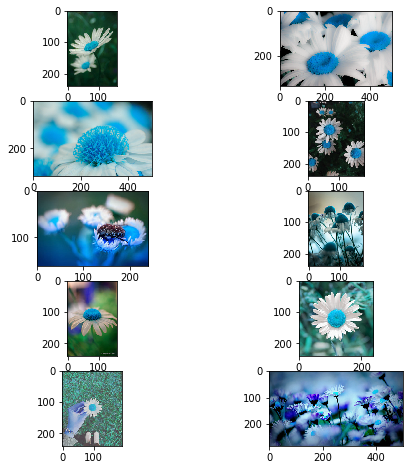

In [11]:
display_images(path_daisy, 10, 5, 2)

In [12]:
# Check filenames extensions
def extension_unique_values(path):
    extensions = [os.listdir(path)[i][-3:] for i in range(len(os.listdir(path)))]
    return set(extensions)

In [13]:
print('daisy: {}'.format(extension_unique_values(path_daisy)))
print('dandelion: {}'.format(extension_unique_values(path_dandelion)))
print('rose: {}'.format(extension_unique_values(path_rose)))
print('sunflower: {}'.format(extension_unique_values(path_sunflower)))
print('tulip: {}'.format(extension_unique_values(path_daisy)))


daisy: {'jpg'}
dandelion: {'jpg'}
rose: {'jpg'}
sunflower: {'jpg'}
tulip: {'jpg'}


In [14]:
filelist_py = [ f for f in os.listdir(path_dandelion) if f.endswith(".py")]
filelist_pyc = [ f for f in os.listdir(path_dandelion) if f.endswith(".pyc")]
filelist_py, filelist_pyc

([], [])

In [15]:
# Delete files that are not images
def clean_dandelion():
    filelist_py = [ f for f in os.listdir(path_dandelion) if f.endswith(".py")]
    filelist_pyc = [ f for f in os.listdir(path_dandelion) if f.endswith(".pyc")]
    for f in filelist_py + filelist_pyc:
        os.remove(os.path.join(path_dandelion, f))

# Delete useless files
clean_dandelion()    

In [16]:
filelist_py = [ f for f in os.listdir(path_dandelion) if f.endswith(".py")]
filelist_pyc = [ f for f in os.listdir(path_dandelion) if f.endswith(".pyc")]
filelist_py, filelist_pyc 

([], [])

# 4. Modelling

In [17]:
# Create dependant variables X and target variable y
images = []
labels = []
img_size = 256

def make_data(flower_type, path):
    
    for filename in os.listdir(path):
        label = flower_type
        path_image = os.path.join(path, filename)
        img = np.array(cv2.imread(path_image, cv2.IMREAD_COLOR)).astype('float32')
        img = cv2.resize(img, (img_size, img_size))
        images.append(img)
        labels.append(label)     
        
make_data("daisy", path_daisy)
make_data("dandelion", path_dandelion)
make_data("rose", path_rose)
make_data("sunflower", path_sunflower)
make_data("tulip", path_tulip)

In [18]:
# Check size compatibility
len(labels), len(images)

(4323, 4323)

In [19]:
# Encode labels
Y = LabelEncoder().fit_transform(labels)
y = to_categorical(Y,5)
# Normalize
X = np.array(images)/255

In [20]:
X.shape

(4323, 256, 256, 3)

In [21]:
# Split train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42)

In [22]:
K.clear_session()

In [23]:
model = applications.VGG19(weights="imagenet", include_top=False, input_shape=(256,256,3))
for layer in model.layers[:5]:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 1s 0us/step


In [24]:
# Add custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [25]:
# createfinal model 
modelFlower = Model(input = model.input, output = predictions)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [26]:
# compile the model 
modelFlower.compile(loss = "categorical_crossentropy", optimizer = SGD(lr=0.0001, momentum=0.9), metrics=["categorical_accuracy"])

In [28]:
# Fit model
batch_size = 150
epochs = 15
modelFlower.fit(X_train, y_train, epochs=epochs,batch_size=batch_size, validation_data = (X_test,y_test))

Instructions for updating:
Use tf.cast instead.
Train on 3026 samples, validate on 1297 samples
Epoch 1/15
3026/3026 [==============================] - 44s 15ms/step - loss: 1.6768 - categorical_accuracy: 0.2310 - val_loss: 1.5211 - val_categorical_accuracy: 0.3655
Epoch 2/15
3026/3026 [==============================] - 33s 11ms/step - loss: 1.5280 - categorical_accuracy: 0.3321 - val_loss: 1.4044 - val_categorical_accuracy: 0.4734
Epoch 3/15
3026/3026 [==============================] - 33s 11ms/step - loss: 1.4153 - categorical_accuracy: 0.4167 - val_loss: 1.3008 - val_categorical_accuracy: 0.5274
Epoch 4/15
3026/3026 [==============================] - 33s 11ms/step - loss: 1.2795 - categorical_accuracy: 0.5063 - val_loss: 1.1262 - val_categorical_accuracy: 0.6068
Epoch 5/15
3026/3026 [==============================] - 33s 11ms/step - loss: 1.1353 - categorical_accuracy: 0.5575 - val_loss: 0.9686 - val_categorical_accuracy: 0.6392
Epoch 6/15
3026/3026 [==============================] 

# 5.  Export model

In [30]:
# serialize model to JSON
model_json = modelFlower.to_json()
with open("modelFlower.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
modelFlower.save_weights("modelFlower.h5")
print("Saved model to disk")

Saved model to disk


In [7]:
json_file = open("application/app/model/modelFlower.json",'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("application/app/model/modelFlower.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
filename = 'modelFlower.pkl'
pickle.dump(loaded_model, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:

 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

In [ ]:
	loaded_model_json = json_file.read()
	json_file.close()
	loaded_model = model_from_json(loaded_model_json)
	loaded_model.load_weights("model/modelFlower.h5")

# 6. Conclusion

Validation accuracy is 0.83. I decide that this model will be deployed for a first version of the applciation.